## Build an ensemble using algorithms and distances, finish to see if it uncovers the lack of structure

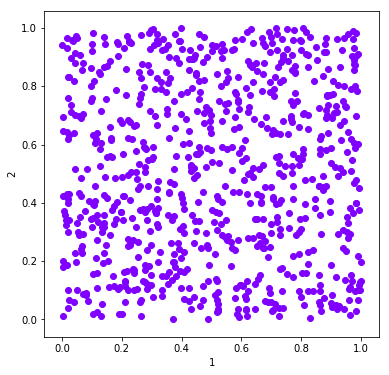

In [1]:
import numpy as np
import pandas as pd 
import openensembles as oe
import matplotlib.pyplot as plt


n_samples = 800
np.random.seed(0)

no_structure = np.random.rand(n_samples, 2), None
X,y = no_structure
df = pd.DataFrame(X)
d = oe.data(df, [1,2])


d.plot_data('parent')
   

### Create an ensemble


In [2]:
c  = oe.cluster(d) #instantiate an object so we can get all available algorithms
a = c.algorithms_available()
#Seteverything to false by default, then change just those that are true
for alg in a.keys():
    a[alg] = False
    
# remove DBSCAN -- this does very well on unstructured data, we want to ask if we can use poorly performing algorithms 
# to identify there isn't structure.
del a['DBSCAN']


takesLinkages = a.copy()
takesDistances = a.copy()
takesK = a.copy() 
takesLinkages['agglomerative'] = True

takesDistances['AffinityPropagation'] = True
takesDistances['agglomerative'] = True

takesK['kmeans'] = True
takesK['agglomerative'] = True
takesK['spectral'] = True


In [3]:
#setup the parameters of clustering here, algorithms are set by algorithms_available
K = range(2,20, 2)
linkages = ['average', 'complete', 'ward'] 
distances = ['euclidean', 'l1', 'l2', 'cosine']


In [4]:
# Create an ensemble: sweep K, distance metrics
c = oe.cluster(d)
for data_source in d.D.keys(): #if there were transformations in d.D
    for algorithm in takesK.keys(): #linkage is only for agglomerative, which also accepts K and distances, so handle that here
        if takesK[algorithm]:
            for k in K:
                if takesDistances[algorithm]:
                    if takesLinkages[algorithm]:
                        for linkage in linkages:
                            if linkage == 'ward':
                                out_name = '_'.join([data_source, algorithm, linkage, str(k)])
                                c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, linkage=linkage)
                            else:
                                for dist in distances:
                                    out_name = '_'.join([data_source, algorithm, dist, linkage, str(k)])
                                    c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, linkage=linkage, distance=dist)



                    else:
                        for dist in distances:
                            out_name = '_'.join([data_source, algorithm, dist, str(k)])
                            c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True, distance=dist)
                else:
                    out_name = '_'.join([data_source, algorithm, str(k)])
                    c.cluster(data_source, algorithm, out_name, K=k, Require_Unique= True)


        else: # does not take K
            if takesDistances[algorithm]:
                    for dist in distances:
                        out_name = '_'.join([data_source, algorithm, dist])
                        c.cluster(data_source, algorithm, out_name, Require_Unique= True, distance=dist)
            else:
                out_name = '_'.join([data_source, algorithm])
                c.cluster(data_source, algorithm, out_name, Require_Unique= True)

        

### Plot example solutions from the ensemble 

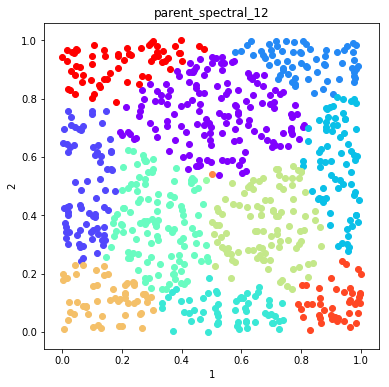

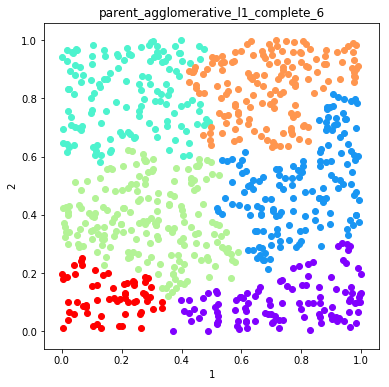

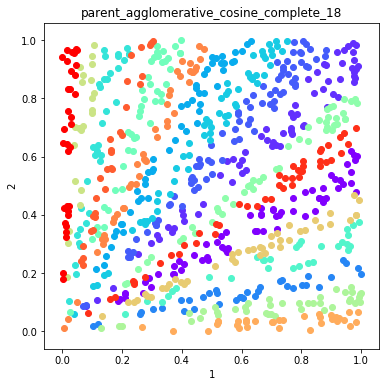

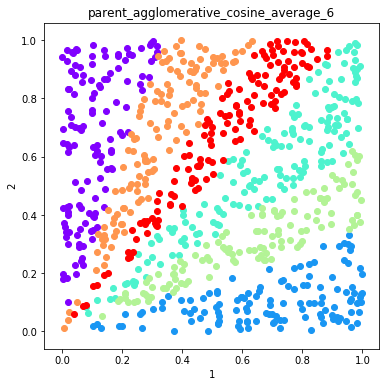

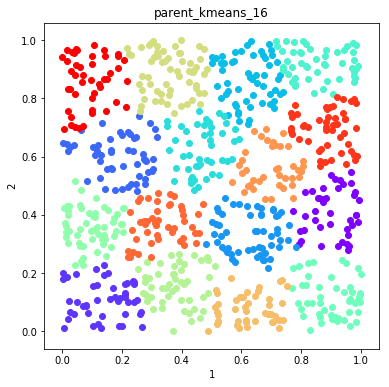

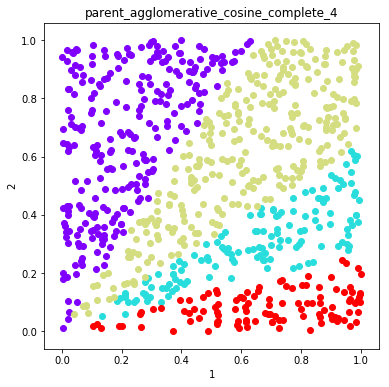

In [7]:
#plot some random number of solutions
names = c.labels.keys()
figs =[]
fig = 0

numSolutions = 6
#namesToSelect = random.sample(names, numSolutions)
namesToSelect = np.random.choice(list(names), numSolutions, replace=False)
for name in namesToSelect:
    d.plot_data('parent', fig_num=fig, class_labels=c.labels[name], title=name)
    plt.show()
    fig+=1
        

### Finish the ensemble using Majority Vote and Graph Closure 

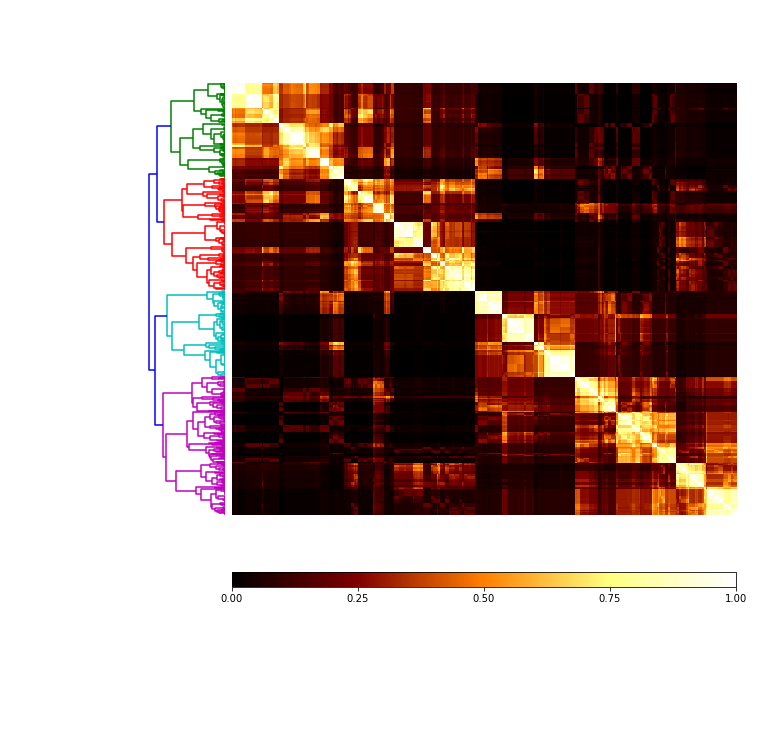

In [8]:
#View the ensembles
coMat = c.co_occurrence_matrix()
fig = coMat.plot(labels=False)
plt.show()

#### Graph Closure and Majority Vote Finishing

In [9]:
# Explore effects of threshold on graph closure
thresholds = [0.5, 0.6, 0.7]
fig = 0
c_graph_dict = {}
c_majority_vote_dict = {}
for threshold in thresholds:
    c_graph = c.finish_graph_closure(threshold=threshold)
    c_graph_dict[str(threshold)] = c_graph
    c_majority_vote = c.finish_majority_vote(threshold=threshold)
    c_majority_vote_dict[str(threshold)] = c_majority_vote

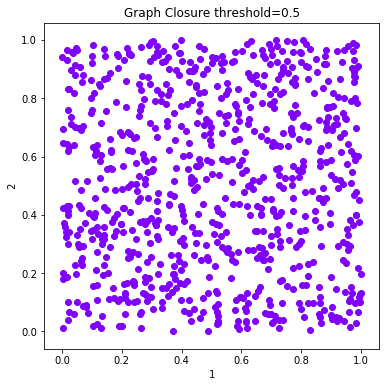

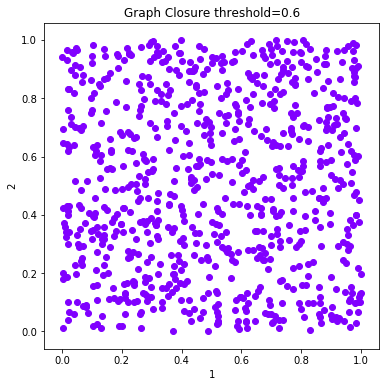

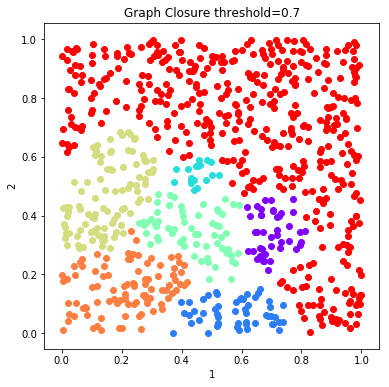

In [19]:
# Plot the solutions of Graph Closure
fig = 0
for threshold in c_graph_dict:
    labels = c_graph_dict[threshold].labels['graph_closure']
    d.plot_data('parent', fig_num = fig, class_labels=labels, title='Graph Closure threshold=%s'%(threshold))
    plt.show()
    fig+=1


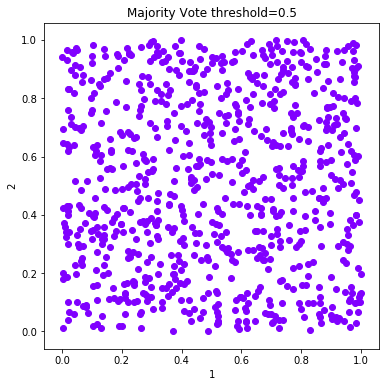

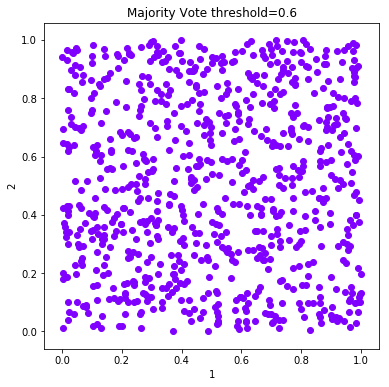

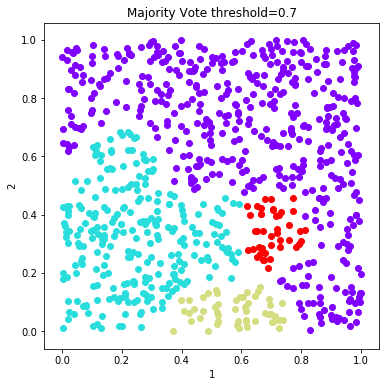

In [18]:
# Plot the solutions of Majority Vote
fig = 0
figs =[]
for threshold in c_majority_vote_dict:
    labels = c_majority_vote_dict[threshold].labels['majority_vote']
    d.plot_data('parent', fig_num = fig, class_labels=labels, title='Majority Vote threshold=%s'%(threshold))
    plt.show()
    fig+=1